# Objective
The objective of this work is to show that k-fold cross validation is better than hold-out in  providing a more stable, and better estimate of performance on small dataset.  
In order to do that, I've chosen the wine dataset (https://archive-beta.ics.uci.edu/dataset/109/wine) and will perform a few hypoteshis tests on using both methods. In this work, we will focus on model accuracy estimate.

In [ ]:
#TODO add here all the package install commands

In [152]:
import pandas as pd
from sklearn.linear_model import SGDRegressor

# Columns for wine.data (taken from wine.names file atached to this work)
wine_cols = ["Class", "Alcohol", "Malic_acid", "Ash", "Alcalinity_of_ash", "Magnesium", 
             "Total_phenols", "Flavanoids", "Nonflavanoid_phenols", "Proanthocyanins", 
             "Color_intensity", "Hue", "OD280_OD315_of_diluted_wines", "Proline"]


wine_pd = pd.read_csv('../input/wine.data', names = wine_cols)
wine_pd.head()

,Class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280_OD315_of_diluted_wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [153]:
from sklearn.preprocessing import StandardScaler

#separate y and x and scale the data
y = wine_pd.pop('Class').values   #target classes
Xraw = wine_pd.values 
# normalise the raw data
scaler = StandardScaler()
X = scaler.fit_transform(Xraw)


In [154]:
# Sets some parms and common vars for all the tests
testSplitSize = 1/3
numberOfTests = 1000
nNeighbors = 3
# opting for average type macro to compute the metrics for each class separetely
averageType = 'macro'
NB=0
KNN=1
DT=2
dtCriterion='entropy'


In [155]:
# This section is about Collecting run data for hold out

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

def splitDataAndRunModel(X, y, randState, model, averageType):
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=randState, 
                                                        test_size=testSplitSize)
    wine_NB = model.fit(X_train, y_train)
    y_dash = wine_NB.predict(X_test)
    
    # calculate precision, recall and f1 scores
    precision = precision_score(y_test, y_dash, average=averageType)
    recall = recall_score(y_test, y_dash, average=averageType)
    f1 = f1_score(y_test, y_dash, average=averageType)
    return {"precision": precision, 
            "recall": recall, 
            "f1": f1}


precisionNbHoldOutList = []
recallNbHoldOutList = []
f1NbHoldOutList = []
nbBestPrecisionHoldOutCount = 0
nbBestRecallHoldOutCount = 0
nbBestF1HoldOutCount = 0

precisionKnnHoldOutList = []
recallKnnHoldOutList = []
f1KnnHoldOutList = []
knnBestPrecisionHoldOutCount = 0
knnBestRecallHoldOutCount = 0
knnBestF1HoldOutCount = 0

precisionDtHoldOutList = []
recallDtHoldOutList = []
f1DtHoldOutList = []
dtBestPrecisionHoldOutCount = 0
dtBestRecallHoldOutCount = 0
dtBestF1HoldOutCount = 0

for randState in range(numberOfTests):    
    # train a NB model and predict for test data
    model = GaussianNB()
    nbResults = splitDataAndRunModel(X, y, randState, model, averageType)
    precisionNbHoldOutList.append(nbResults['precision'])
    recallNbHoldOutList.append(nbResults['recall'])
    f1NbHoldOutList.append(nbResults['f1'])
    
    # train a KNN model and predict for test data
    model = KNeighborsClassifier(n_neighbors=nNeighbors)  
    knnResults = splitDataAndRunModel(X, y, randState, model, averageType)
    precisionKnnHoldOutList.append(knnResults['precision'])
    recallKnnHoldOutList.append(knnResults['recall'])
    f1KnnHoldOutList.append(knnResults['f1'])
    
    # train a Decision Tree model and predict for test data
    model = DecisionTreeClassifier(criterion=dtCriterion)
    dtResults = splitDataAndRunModel(X, y, randState, model, averageType)
    precisionDtHoldOutList.append(dtResults['precision'])
    recallDtHoldOutList.append(dtResults['recall'])
    f1DtHoldOutList.append(dtResults['f1'])
    

    #add to couters of best precision, recall and f1
    #precision
    precisionList = [nbResults['precision'], knnResults['precision'],dtResults['precision']]
    highestPrecisionItem = precisionList.index(max(precisionList))
    if highestPrecisionItem == NB:
        nbBestPrecisionHoldOutCount = nbBestPrecisionHoldOutCount + 1
    elif highestPrecisionItem == KNN:
        knnBestPrecisionHoldOutCount = knnBestPrecisionHoldOutCount + 1
    else:
        dtBestPrecisionHoldOutCount = dtBestPrecisionHoldOutCount + 1        
    #recall
    recallList = [nbResults['recall'], knnResults['recall'],dtResults['recall']]
    highestRecallItem = recallList.index(max(recallList))
    if highestRecallItem == NB:
        nbBestRecallHoldOutCount = nbBestRecallHoldOutCount + 1
    elif highestRecallItem == KNN:
        knnBestRecallHoldOutCount = knnBestRecallHoldOutCount + 1
    else:
        dtBestRecallHoldOutCount = dtBestRecallHoldOutCount + 1        
    #f1
    f1List = [nbResults['f1'], knnResults['f1'],dtResults['f1']]
    highestF1Item = f1List.index(max(f1List))
    if highestF1Item == NB:
        nbBestF1HoldOutCount = nbBestF1HoldOutCount + 1
    elif highestF1Item == KNN:
        knnBestF1HoldOutCount = knnBestF1HoldOutCount + 1
    else:
        dtBestF1HoldOutCount = dtBestF1HoldOutCount + 1            


In [156]:
# This section is about collecting data for cross validation

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score


def splitDataCrossValAndRunModel(X, y, randState, model, averageType, cvRand):
    precision = cross_val_score(model, X, y, cv=cvRand, n_jobs=-1, scoring = 'precision_'+ averageType).mean()
    recall = cross_val_score(model, X, y, cv=cvRand, n_jobs=-1, scoring = 'recall_'+ averageType).mean()
    f1 = cross_val_score(model, X, y, cv=cvRand, n_jobs=-1, scoring = 'f1_'+ averageType).mean()    
    return {"precision": precision, 
            "recall": recall, 
            "f1": f1}


precisionNbCrossValList = []
recallNbCrossValList = []
f1NbCrossValList = []
nbBestPrecisionCrossValCount = 0
nbBestRecallCrossValCount = 0
nbBestF1CrossValCount = 0

precisionKnnCrossValList = []
recallKnnCrossValList = []
f1KnnCrossValList = []
knnBestPrecisionCrossValCount = 0
knnBestRecallCrossValCount = 0
knnBestF1CrossValCount = 0

precisionDtCrossValList = []
recallDtCrossValList = []
f1DtCrossValList = []
dtBestPrecisionCrossValCount = 0
dtBestRecallCrossValCount = 0
dtBestF1CrossValCount = 0

for randState in range(numberOfTests):    
    # creates a cross validation iterator that randomly assings the splits
    cvRand = ShuffleSplit(n_splits=10, test_size=testSplitSize, random_state=randState)

    # train a NB model and predict for test data
    model = GaussianNB()
    nbResults = splitDataCrossValAndRunModel(X, y, randState, model, averageType, cvRand)
    precisionNbCrossValList.append(nbResults['precision'])
    recallNbCrossValList.append(nbResults['recall'])
    f1NbCrossValList.append(nbResults['f1'])
    
    # train a KNN model and predict for test data
    model = KNeighborsClassifier(n_neighbors=nNeighbors)  
    knnResults = splitDataCrossValAndRunModel(X, y, randState, model, averageType, cvRand)
    precisionKnnCrossValList.append(knnResults['precision'])
    recallKnnCrossValList.append(knnResults['recall'])
    f1KnnCrossValList.append(knnResults['f1'])
    
    # train a Decision Tree model and predict for test data
    model = DecisionTreeClassifier(criterion=dtCriterion)
    dtResults = splitDataCrossValAndRunModel(X, y, randState, model, averageType, cvRand)
    precisionDtCrossValList.append(dtResults['precision'])
    recallDtCrossValList.append(dtResults['recall'])
    f1DtCrossValList.append(dtResults['f1'])
    

    #add to couters of best precision, recall and f1
    #precision
    precisionList = [nbResults['precision'], knnResults['precision'],dtResults['precision']]
    highestPrecisionItem = precisionList.index(max(precisionList))
    if highestPrecisionItem == NB:
        nbBestPrecisionCrossValCount = nbBestPrecisionCrossValCount + 1
    elif highestPrecisionItem == KNN:
        knnBestPrecisionCrossValCount = knnBestPrecisionCrossValCount + 1
    else:
        dtBestPrecisionCrossValCount = dtBestPrecisionCrossValCount + 1        
    #recall
    recallList = [nbResults['recall'], knnResults['recall'],dtResults['recall']]
    highestRecallItem = recallList.index(max(recallList))
    if highestRecallItem == NB:
        nbBestRecallCrossValCount = nbBestRecallCrossValCount + 1
    elif highestRecallItem == KNN:
        knnBestRecallCrossValCount = knnBestRecallCrossValCount + 1
    else:
        dtBestRecallCrossValCount = dtBestRecallCrossValCount + 1        
    #f1
    f1List = [nbResults['f1'], knnResults['f1'],dtResults['f1']]
    highestF1Item = f1List.index(max(f1List))
    if highestF1Item == NB:
        nbBestF1CrossValCount = nbBestF1CrossValCount + 1
    elif highestF1Item == KNN:
        knnBestF1CrossValCount = knnBestF1CrossValCount + 1
    else:
        dtBestF1CrossValCount = dtBestF1CrossValCount + 1            



### Model performance distribution on Hold Out vs Cross Validation

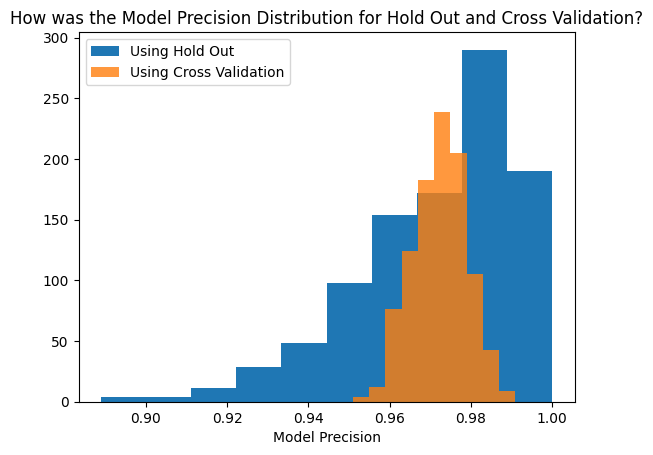

In [207]:
import matplotlib.pyplot as plt
def roundList(aList):
    return list(map(lambda x: round(x, ndigits=3), aList))
    

plt.hist(roundList(precisionNbHoldOutList), label="Using Hold Out")
plt.hist(roundList(precisionNbCrossValList), alpha=0.8, label="Using Cross Validation")
plt.title("How was the Model Precision Distribution for Hold Out and Cross Validation?")
plt.xlabel("Model Precision")
plt.legend(loc='upper left')


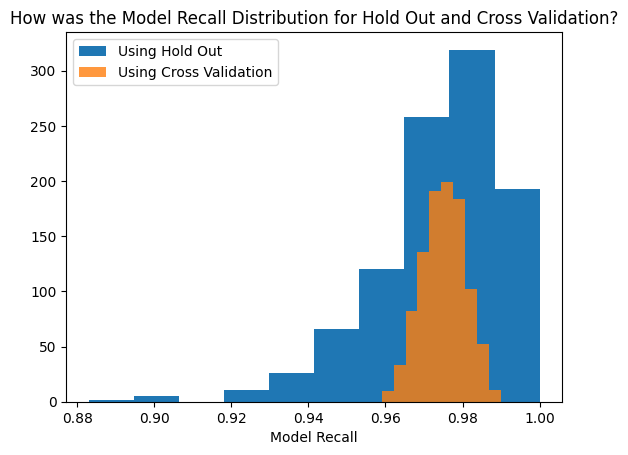

In [208]:
plt.hist(roundList(recallNbHoldOutList), label="Using Hold Out")
plt.hist(roundList(recallNbCrossValList), alpha=0.8, label="Using Cross Validation")
plt.title("How was the Model Recall Distribution for Hold Out and Cross Validation?")
plt.xlabel("Model Recall")
plt.legend(loc='upper left')


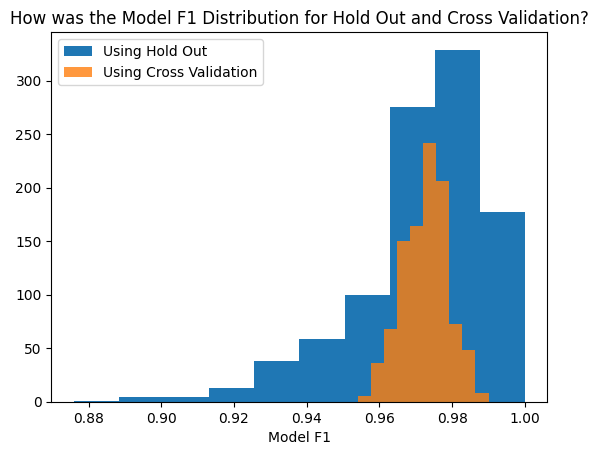

In [209]:
plt.hist(roundList(f1NbHoldOutList), label="Using Hold Out")
plt.hist(roundList(f1NbCrossValList), alpha=0.8, label="Using Cross Validation")
plt.title("How was the Model F1 Distribution for Hold Out and Cross Validation?")
plt.xlabel("Model F1")
plt.legend(loc='upper left')


### How many times I'd choose each algoritm on Hold Out vs Cross Validation?

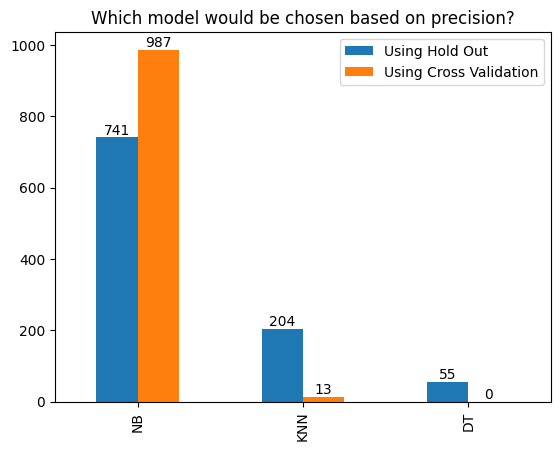

In [169]:

df = pd.DataFrame({'Using Hold Out': [nbBestPrecisionHoldOutCount, knnBestPrecisionHoldOutCount, dtBestPrecisionHoldOutCount],
                   'Using Cross Validation': [nbBestPrecisionCrossValCount, knnBestPrecisionCrossValCount, dtBestPrecisionCrossValCount]}, 
                  index=['NB', 'KNN', 'DT'])

ax = df.plot.bar(title="Which model would be chosen based on precision?")
for container in ax.containers:
    ax.bar_label(container)

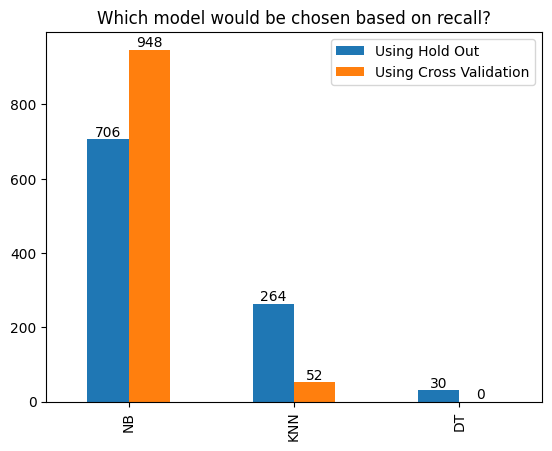

In [168]:
import matplotlib.pyplot as plt
df = pd.DataFrame({'Using Hold Out': [nbBestRecallHoldOutCount, knnBestRecallHoldOutCount, dtBestRecallHoldOutCount],
                   'Using Cross Validation': [nbBestRecallCrossValCount, knnBestRecallCrossValCount, dtBestRecallCrossValCount]}, 
                  index=['NB', 'KNN', 'DT'])

ax = df.plot.bar(title="Which model would be chosen based on recall?")


for container in ax.containers:
    ax.bar_label(container)

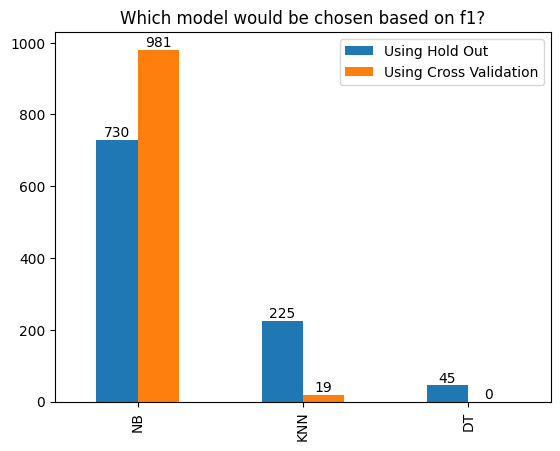

In [170]:
import matplotlib.pyplot as plt
df = pd.DataFrame({'Using Hold Out': [nbBestF1HoldOutCount, knnBestF1HoldOutCount, dtBestF1HoldOutCount],
                   'Using Cross Validation': [nbBestF1CrossValCount, knnBestF1CrossValCount, dtBestF1CrossValCount]}, 
                  index=['NB', 'KNN', 'DT'])

ax = df.plot.bar(title="Which model would be chosen based on f1?")

for container in ax.containers:
    ax.bar_label(container)

In [ ]:
TODO write conclusions of the data and organize imports